In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from flask import Flask, jsonify

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector=inspect(engine)
for column in inspector.get_columns('measurement'):
      print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


2017-08-23


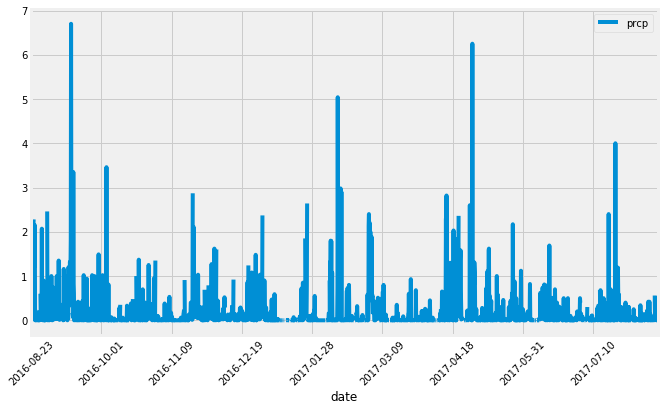

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
latest=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest=latest[0]
latest=dt.datetime.strptime(latest, '%Y-%m-%d').date()
print(latest)
# Perform a query to retrieve the data and precipitation scores
twelve_months=session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>=latest-dt.timedelta(days=365))
# # Save the query results as a Pandas DataFrame and set the index to the date column
result_df=pd.DataFrame(twelve_months)
result_df.set_index("date",inplace=True)
# Sort the dataframe by date
result_df.sort_values("date",inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data
result_df.prcp.plot(legend = 'precipitation', figsize= (10, 6), rot=45)
# result_df.plot.bar(figsize=(15,10), width=4)
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
result_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
number_of_stations=session.query(Measurement.station).group_by(Measurement.station).count()
number_of_stations

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_counts=session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
summary_stats=session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station=='USC00519281').all()
summary_stats

[(54.0, 85.0, 71.66378066378067)]

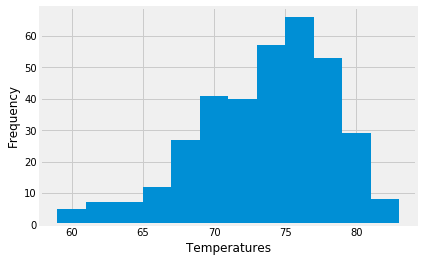

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results=session.query(Measurement.tobs).filter(Measurement.station=='USC00519281').filter(Measurement.date>=latest-dt.timedelta(days=365)).all()
results_df=pd.DataFrame(results)
plt.hist(results_df["tobs"],bins=12)
plt.ylabel("Frequency")
plt.xlabel("Temperatures")
plt.show()

# Part 2 Located in app.py

## Temperature Analysis 1

In [17]:
import scipy.stats as stats
june = session.query(Measurement.tobs).filter(func.strftime('%m',Measurement.date)=="06").all()
dec = session.query(Measurement.tobs).filter(func.strftime('%m',Measurement.date)=="12").all()
print(f'June: {np.ravel(june).mean()}')
print(f'Dec: {np.ravel(dec).mean()}')
print(stats.ttest_ind(np.ravel(june),np.ravel(dec)))
print(f'We use an un-paired t-testbecause we are trying to see if two popuulations are significantly different. Beacuse the P-value is so low we can assume that they are.')


June mean: 74.94411764705882
Dec mean: 71.04152933421226
Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)
We use an un-paired t-testbecause we are trying to see if two popuulations are significantly different. Beacuse the P-value is so low we can assume that they are.


## Temperature Analysis 2

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(f'Trip dates = 2017-08-18 through 2017-08-27')
trip=calc_temps('2016-08-18', '2016-08-27')
print(trip)
avg_temp=trip[0][1]
min_temp=trip[0][0]
max_temp=trip[0][2]

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig,ax = plt.subplots(figsize=(4,10))
plt.bar('',temp_avg,yerr=(temp_max-temp_min),alpha=0.5)
plt.grid(False,axis='x')
plt.title('Average Temperature for August 18, 2016 through August 27, 2016')
plt.show()

In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station,Measurement.prcp, Station.name, Station.latitude, Station.longitude, Station.elevation]
rain = session.query(*sel).filter(Measurement.station==Station.station).filter(Measurement.date.between('2016-08-18', '2016-08-27')).order_by(Measurement.prcp.desc()).all()
rain_df = pd.DataFrame(rain)
rain_grouped_df=rain_df.groupby(["station","latitude","longitude","elevation"]).sum()
rain_grouped_df


## Optional Challenge Assignment

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [39]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
normals=[]
for i in range(10):
    normals.append(daily_normals(f"08-{18+i}")[0])
#     print(18+i)
normals

[(70.0, 76.92307692307692, 84.0),
 (69.0, 75.94642857142857, 85.0),
 (68.0, 76.45283018867924, 82.0),
 (67.0, 76.4, 83.0),
 (69.0, 76.47169811320755, 84.0),
 (67.0, 76.6923076923077, 87.0),
 (70.0, 75.96153846153847, 84.0),
 (69.0, 76.96078431372548, 82.0),
 (71.0, 76.56862745098039, 84.0),
 (68.0, 76.28301886792453, 84.0)]

In [36]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
dates=[]
for i in range(10):
    dates.append(f"2016-08-{18+i}")
#     print(18+i)
dates
normal_df=pd.DataFrame(normals, columns=["Min","Avg","Max"])
normal_df["date"]=dates
normal_df.set_index("date", inplace=True)
normal_df

,Min,Avg,Max
date,,,
2016-08-18,70.0,76.923077,84.0
2016-08-19,69.0,75.946429,85.0
2016-08-20,68.0,76.452830,82.0
2016-08-21,67.0,76.400000,83.0
2016-08-22,69.0,76.471698,84.0
2016-08-23,67.0,76.692308,87.0
2016-08-24,70.0,75.961538,84.0
2016-08-25,69.0,76.960784,82.0
2016-08-26,71.0,76.568627,84.0


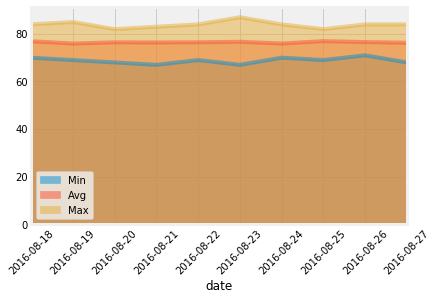

In [40]:
# Plot the daily normals as an area plot with `stacked=False`
normal_df.plot.area(stacked=False,rot=45)
plt.show()